# Twitter Sentiment Analysis

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
sns.set_style("darkgrid")

In [3]:
class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

data_path='/home/jishnu/Documents/ISB/Term3/practicum/workspace/data_collection/data/daily_data'
with cd(data_path):
    listings_file = max(glob.iglob('listings_*'), key=os.path.getctime)
    ticker_file = max(glob.iglob('ticker_data_*'), key=os.path.getctime)
    global_file = max(glob.iglob('global_data_*'), key=os.path.getctime)
    bitcoin_tweets_file = max(glob.iglob('bitcoin_tweets_*'), key=os.path.getctime)
    ethereum_tweets_file = max(glob.iglob('ethereum_tweets_*'), key=os.path.getctime)
    ripple_tweets_file = max(glob.iglob('ripple_tweets_*'), key=os.path.getctime)

listings_file = os.path.join(data_path,listings_file)
ticker_file = os.path.join(data_path,ticker_file)
global_file = os.path.join(data_path,global_file)
bitcoin_tweets_file = os.path.join(data_path,bitcoin_tweets_file)
ethereum_tweets_file = os.path.join(data_path,ethereum_tweets_file)
ripple_tweets_file = os.path.join(data_path,ripple_tweets_file)

In [4]:
listings = pd.read_csv(listings_file)
ticker_data = pd.read_csv(ticker_file)
global_data = pd.read_csv(global_file)
bitcoin_tweets = pd.read_table(bitcoin_tweets_file,sep='###!###',
                       header=None,names=['tweet_no','user','date','location','tweet'],
                       parse_dates=['date'],engine='python')
ethereum_tweets = pd.read_table(ethereum_tweets_file,sep='###!###',
                       header=None,names=['tweet_no','user','date','location','tweet'],
                       parse_dates=['date'],engine='python')
ripple_tweets = pd.read_table(ripple_tweets_file,sep='###!###',
                       header=None,names=['tweet_no','user','date','location','tweet'],
                       parse_dates=['date'],engine='python')

In [5]:
bitcoin_tweets['tweet'].count()

94

Creating dictionary which holds the three dataframes (to facilitate iteration)

In [6]:
tweets_df_dict = {'bitcoin' : bitcoin_tweets,'ethereum' : ethereum_tweets,'ripple' : ripple_tweets}

## Preprocessing tweets

In [7]:
for currency in tweets_df_dict:
    tweets_df_dict[currency]['tweetos'] = ''
    tweets_df_dict[currency]['tweet_clean'] = ''
    #add tweetos first part
    for i in range(len(tweets_df_dict[currency]['tweet'])):
        try:
            tweets_df_dict[currency].iloc[i,5] = tweets_df_dict[currency]['tweet'].str.split(' ')[i][1]
        except AttributeError:    
            tweets_df_dict[currency].iloc[i,5] = 'other'

    #Preprocessing tweetos. select tweetos contains 'b@'
    for i in range(len(tweets_df_dict[currency]['tweet'])):
        if tweets_df_dict[currency]['tweetos'].str.contains('@')[i]  == False:
            tweets_df_dict[currency].iloc[i,5] = 'other'

    # remove URLs, RTs, and twitter handles
    for i in range(len(tweets_df_dict[currency]['tweet'])):
        tweets_df_dict[currency].iloc[i,6] = " ".join([word for word in tweets_df_dict[currency]['tweet'][i].split()
                                    if 'http' not in word and '@' not in word and '<' not in word])
    tweets_df_dict[currency]['tweet_clean'] = tweets_df_dict[currency]['tweet_clean'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
    tweets_df_dict[currency]['tweet_clean'] = tweets_df_dict[currency]['tweet_clean'].apply(lambda x: re.sub('  ', ' ', x))
    

## Plotting word clouds for tweets, locations

Word Cloud for bitcoin tweets


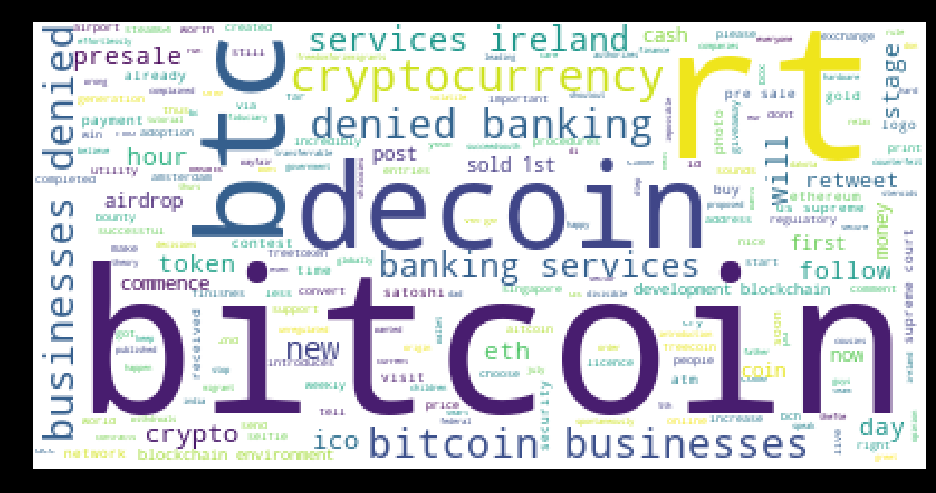

Word Cloud for ethereum tweets


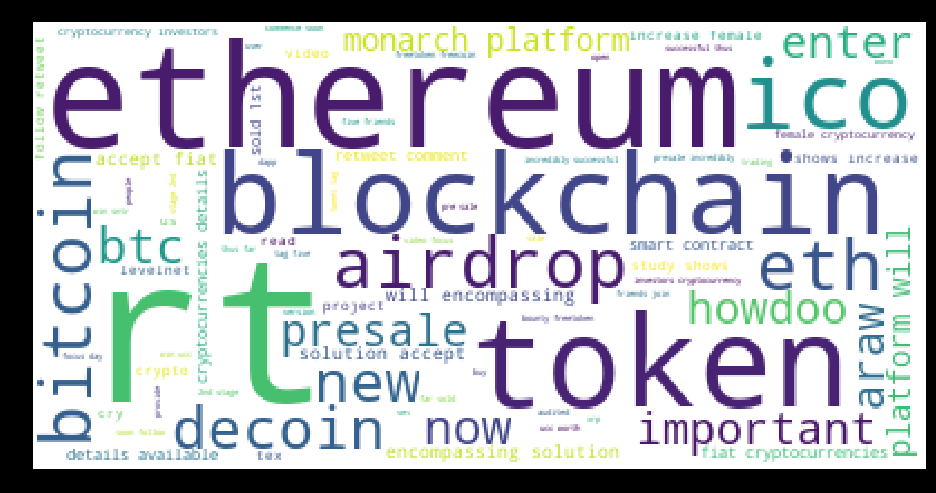

Word Cloud for ripple tweets


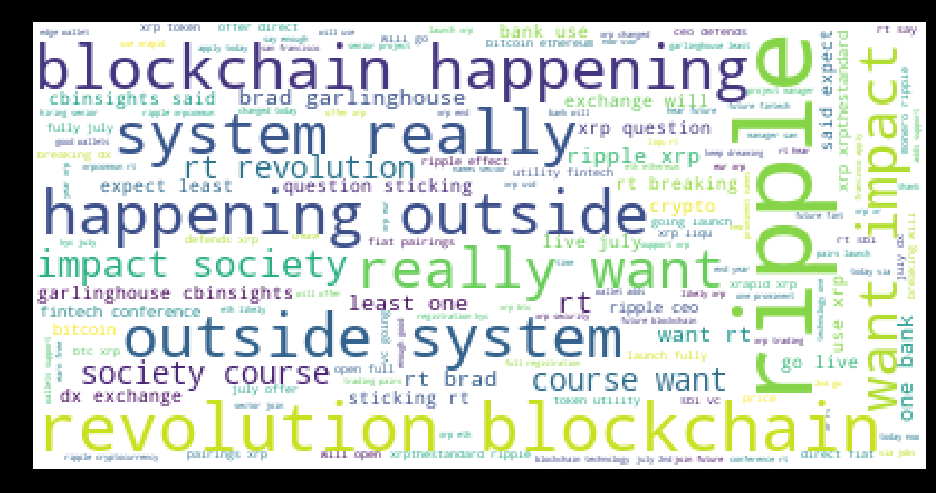

In [29]:
def wordcloud(tweets,col,currency,querytype):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",
                          stopwords=stopwords,
                          random_state = 2016).generate(" ".join([i for i in tweets[tweets[col].notnull()][col]]))
    print('Word Cloud for %s %s' % (currency,querytype))
    plt.figure( figsize=(16,9), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

for currency in tweets_df_dict:
    wordcloud(tweets_df_dict[currency],'tweet_clean',currency,'tweets')  

Word Cloud for bitcoin locations


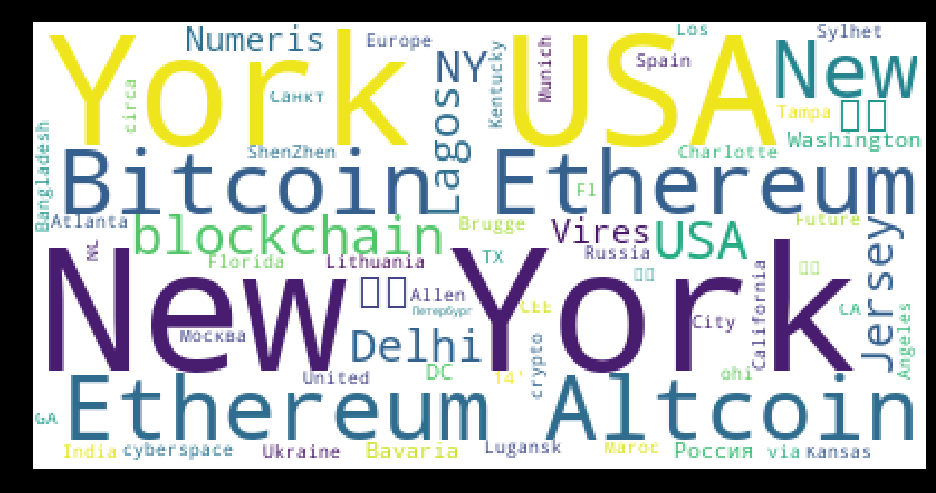

Word Cloud for ethereum locations


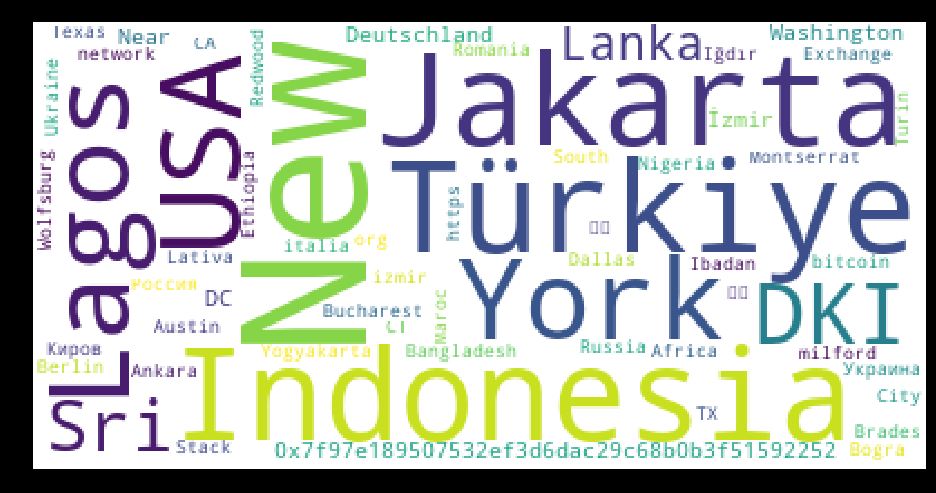

Word Cloud for ripple locations


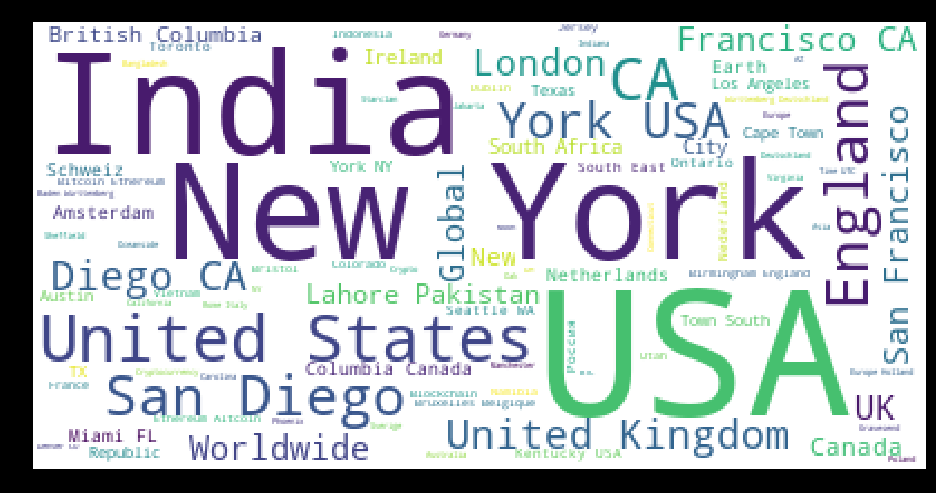

In [31]:
for currency in tweets_df_dict:
    wordcloud(tweets_df_dict[currency],'location',currency,'locations')  

## Running Sentiment Analysis

In [8]:
for currency in tweets_df_dict:
    tweets_df_dict[currency]['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets_df_dict[currency]['tweet_clean']]       
    vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
    X = vectorizer.fit_transform(tweets_df_dict[currency]['text_lem'].str.upper())
    sid = SentimentIntensityAnalyzer()
    tweets_df_dict[currency]['sentiment_compound_polarity']=tweets_df_dict[currency].text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
    tweets_df_dict[currency]['sentiment_neutral']=tweets_df_dict[currency].text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
    tweets_df_dict[currency]['sentiment_negative']=tweets_df_dict[currency].text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
    tweets_df_dict[currency]['sentiment_pos']=tweets_df_dict[currency].text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
    tweets_df_dict[currency]['sentiment_type']=''
    tweets_df_dict[currency].loc[tweets_df_dict[currency].sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
    tweets_df_dict[currency].loc[tweets_df_dict[currency].sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
    tweets_df_dict[currency].loc[tweets_df_dict[currency].sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

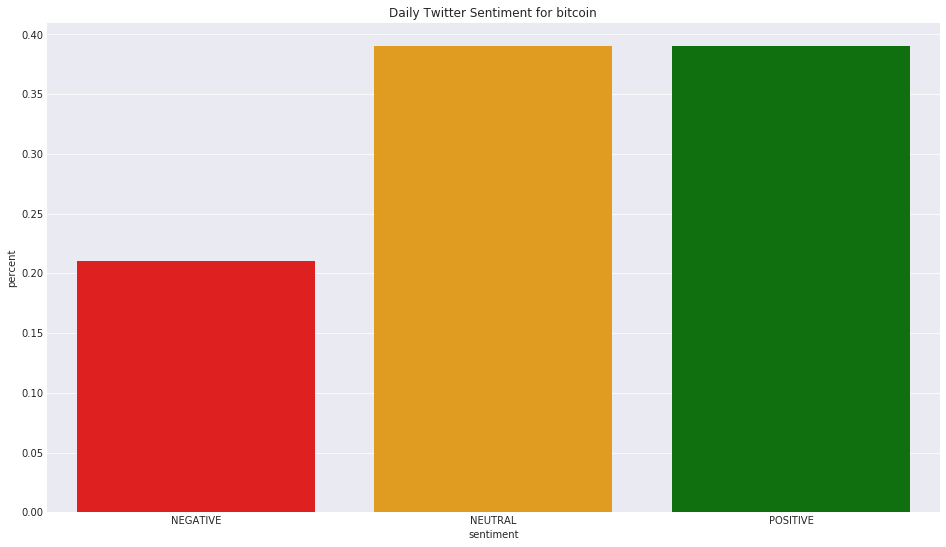

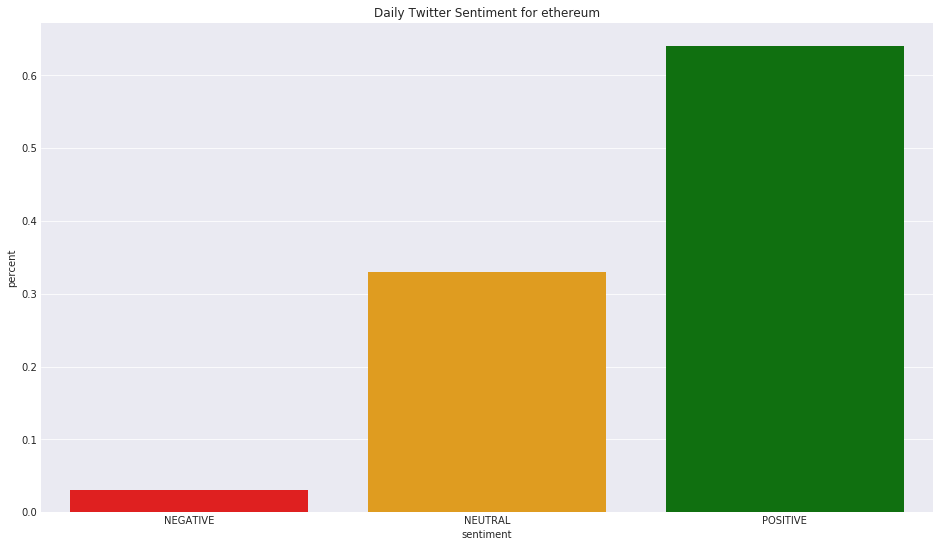

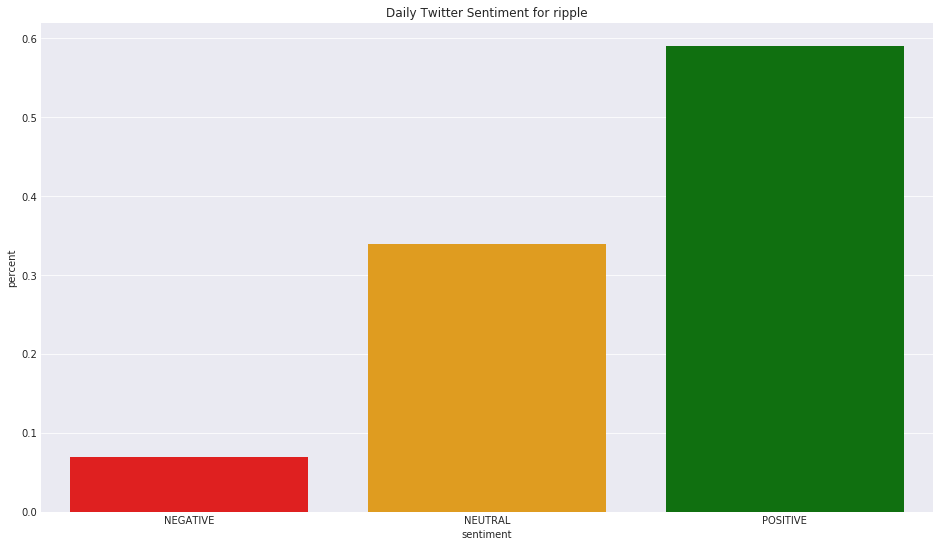

In [9]:
for currency in tweets_df_dict:
    tweets_sentiment = tweets_df_dict[currency].groupby(['sentiment_type'])['sentiment_neutral'].count()
    tweets_sentiment = pd.DataFrame(tweets_sentiment).reset_index()
    tweets_sentiment.columns=['sentiment','count']
    sum_count = tweets_sentiment['count'].sum()
    tweets_sentiment['percent'] = tweets_sentiment.apply(lambda row:np.round(row['count']/sum_count,2),axis=1)
    f,ax=plt.subplots(figsize=(16,9))
    ax.set_title('Daily Twitter Sentiment for %s' % currency)
    sns.barplot(x='sentiment',y='percent',data=tweets_sentiment,palette=['red','orange','green'])
    plt.show();

In [25]:
tweets_sentiment.loc[tweets_sentiment['sentiment'] == 'POSITIVE']['percent'].values[0]

0.58999999999999997